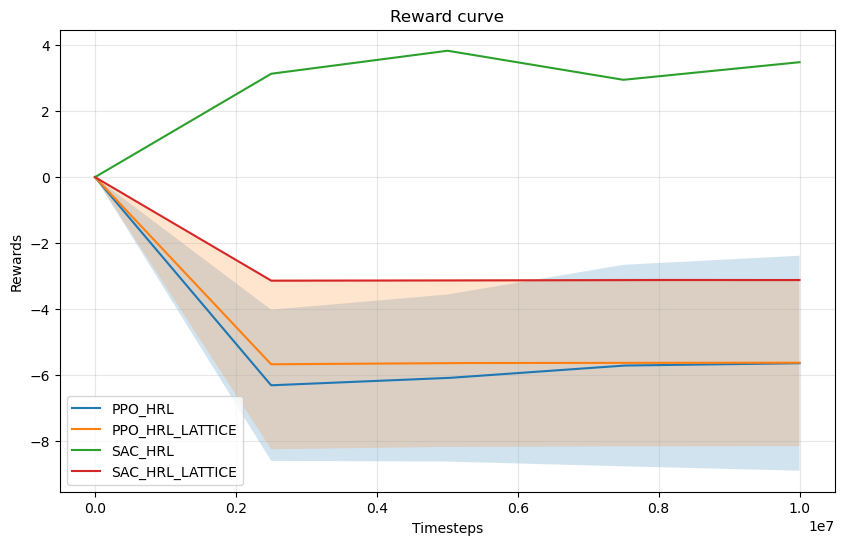

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def load_tf_events(log_dir, path, model_name, rescale_factor=1.0):
    """Loads all event files in a directory and returns a concatenated DataFrame."""
    all_data = []
    log_root = "./logs"
    log_dir = os.path.join(log_root, log_dir)
    
    # Iterate through run folders (e.g., model_v1_run1, model_v1_run2)
    for run_name in os.listdir(log_dir):
        run_path = os.path.join(log_dir, run_name, path)
        if not os.path.isdir(run_path): continue
        
        ea = event_accumulator.EventAccumulator(run_path)
        ea.Reload()
        
        tag = 'eval/mean_reward' 
        if tag in ea.Tags()['scalars']:
            events = ea.Scalars(tag)
            data = [(0, 0)] + [(e.step * rescale_factor, e.value) for e in events]
            df = pd.DataFrame(data, columns=['step', 'value'])
            df['model'] = model_name
            df['run'] = run_name
            all_data.append(df)
            
    return pd.concat(all_data) if all_data else pd.DataFrame()

# 1. Define your paths and settings
model_configs = {
    # "PPO": {"folder": "PPO", "path": "PPO_1", "rescale": 1.0},
    # "PPO_LATTICE": {"folder": "PPO_LATTICE", "path": "RecurrentPPO_1", "rescale": 1.0},
    "PPO_HRL": {"folder": "PPO_HRL", "path": "manager/PPO_1", "rescale": 5.0},
    "PPO_HRL_LATTICE": {"folder": "PPO_HRL_LATTICE", "path": "manager/PPO_1", "rescale": 5.0},
    # "SAC": {"folder": "SAC", "path": "manager/SAC_1", "rescale": 1.0},
    # "SAC_LATTICE": {"folder": "SAC_LATTICE", "path": "manager/SAC_1", "rescale": 1.0},
    "SAC_HRL": {"folder": "SAC_HRL", "path": "manager/SAC_1", "rescale": 5.0},
    "SAC_HRL_LATTICE": {"folder": "SAC_HRL_LATTICE", "path": "manager/SAC_1", "rescale": 5.0}
}

plt.figure(figsize=(10, 6))

for model_label, config in model_configs.items():
    df = load_tf_events(config['folder'], config['path'], model_label, config['rescale'])
    
    if df.empty: continue

    # 2. Process Data: Interpolate to a common x-axis for averaging
    # This handles cases where runs have slightly different step counts
    steps_uniform = np.linspace(df['step'].min(), df['step'].max(), 1000)
    interp_values = []

    for run in df['run'].unique():
        run_data = df[df['run'] == run]
        v = np.interp(steps_uniform, run_data['step'], run_data['value'])
        interp_values.append(v)

    # 3. Calculate Mean and Std
    interp_values = np.array(interp_values)
    mean_vals = np.mean(interp_values, axis=0)
    std_vals = np.std(interp_values, axis=0)

    # 4. Plot
    plt.plot(steps_uniform, mean_vals, label=model_label)
    plt.fill_between(steps_uniform, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)

# Formatting
plt.title("Reward curve")
plt.xlabel("Timesteps")
plt.ylabel("Rewards")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("rewards-hrl.png")